<a href="https://colab.research.google.com/github/meilinshi/Concept-Drift-Formalization-COSIT-Case-Study/blob/main/COSIT_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
file_url = 'https://raw.githubusercontent.com/meilinshi/Concept-Drift-Formalization-COSIT-Case-Study/main/Data/cosit_data.csv'

def preprocess(file_url):
    df = pd.read_csv(file_url)
    df['Title'] = df['Title'].str.replace('\n', '')
    df['Keywords'] = df['Keywords'].str.replace(', ', ',')
    df['Year'] = df['Year'].astype(int)

    # Explode the Keywords column to separate each keyword into a separate row
    df['Keywords'] = df['Keywords'].str.lower().str.split(',')
    df_expanded = df.explode('Keywords')
    return df_expanded

df = preprocess(file_url)
df

,Year,Title,Abstract,Keywords
0,1992,Do people understand spatial concepts: The cas...,The purpose of this paper is to examine whethe...,geographic information system
0,1992,Do people understand spatial concepts: The cas...,The purpose of this paper is to examine whethe...,spatial relation
0,1992,Do people understand spatial concepts: The cas...,The purpose of this paper is to examine whethe...,spatial ability
0,1992,Do people understand spatial concepts: The cas...,The purpose of this paper is to examine whethe...,spatial knowledge
1,1992,Temporal databases,"This paper summarizes the major concepts, appr...",query language
...,...,...,...,...
109,2022,Representing Computational Relations in Knowle...,Knowledge representation is the cornerstone of...,spatial relation
109,2022,Representing Computational Relations in Knowle...,Knowledge representation is the cornerstone of...,computational relation
109,2022,Representing Computational Relations in Knowle...,Knowledge representation is the cornerstone of...,functional programming
109,2022,Representing Computational Relations in Knowle...,Knowledge representation is the cornerstone of...,haskell


In [6]:
# get paper count statistics
df.groupby(['Year'])['Title'].count()

Year
1992    122
2001    171
2011    107
2022    147
Name: Title, dtype: int64

In [7]:
# get keyword count statistics
keyword_counts = df.groupby(['Keywords']).size().reset_index(name='Count')
keyword_counts = keyword_counts[keyword_counts['Count'] >= 5] #.sort_values(by='Count', ascending=False)
keywords = keyword_counts['Keywords']
keyword_counts

,Keywords,Count
124,geographic information system,7
231,navigation,5
277,qualitative spatial reasoning,6
360,spatial cognition,8
376,spatial knowledge,5
389,spatial reasoning,11


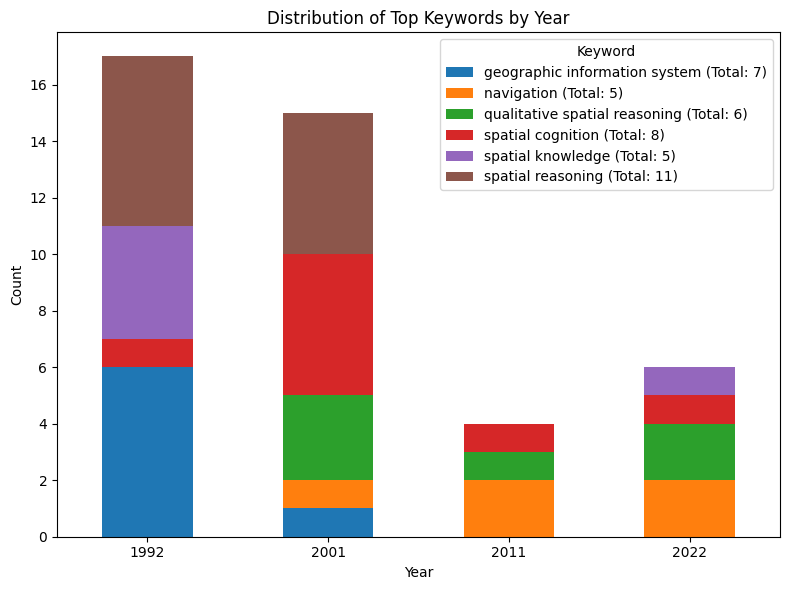

In [8]:
# Figure 1 - Distribution and frequency of top keywords by year

import matplotlib.pyplot as plt
filtered_df = df[df['Keywords'].isin(keywords)]

# Group by year and keyword, then count occurrences
keyword_counts = filtered_df.groupby(['Year', 'Keywords']).size().unstack(fill_value=0)

# Plot distribution
keyword_counts.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Distribution of Top Keywords by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)


total_counts = filtered_df['Keywords'].value_counts()

# Create legend with total counts
legend_labels = [f'{keyword} (Total: {total_counts[keyword]})' for keyword in keywords]
plt.legend(legend_labels, title='Keyword')

plt.tight_layout()
plt.show()

In [ ]:
# generate contextual embeddings based on paper title and abstract

def generate_keyword_embeddings(df):

    # Load the pretrained SciBERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
    model = BertModel.from_pretrained("allenai/scibert_scivocab_uncased")


    # Group the DataFrame by 'year' and 'keyword', and aggregate 'title' and 'abstract'
    grouped_df = df.groupby(['Year', 'Keywords']).agg({'Title': ' '.join, 'Abstract': ' '.join}).reset_index()

    # Create a list to store dictionaries for each year, keyword, and embedding
    rows = []

    # Iterate through each group
    for index, row in grouped_df.iterrows():
        text = row['Title'] + ' ' + row['Abstract']
        year = row['Year']
        keyword = row['Keywords']

        # Tokenize the text using SciBERT tokenizer
        tokens = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512, return_tensors="pt")

        # Generate embedding for the tokens using SciBERT model
        with torch.no_grad():
            outputs = model(tokens)
            embedding = outputs[0][:, 0, :].squeeze().numpy()

        # Append a dictionary with year, keyword, and embedding to the list
        rows.append({'Year': year, 'Keyword': keyword, 'Embedding': embedding})

    # Create a DataFrame from the list of dictionaries
    embeddings_df = pd.DataFrame(rows)

    return embeddings_df

In [ ]:
embeddings = generate_keyword_embeddings(df)
embeddings

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

,Year,Keyword,Embedding
0,1992,adjacent triangle,"[0.062276527, 0.15055275, 0.27586696, -0.88408..."
1,1992,automatic learning,"[-0.278703, 0.29295003, -0.9847082, -0.0032892..."
2,1992,average farm size,"[0.0156218, 0.31561887, -0.20980045, 0.0717567..."
3,1992,boundary edge,"[0.062276527, 0.15055275, 0.27586696, -0.88408..."
4,1992,boundary segment,"[-0.14329734, -0.3568451, 0.653597, 0.19310884..."
...,...,...,...
491,2022,urban traffic system,"[-0.07444569, 0.40416187, -0.77625215, 0.49603..."
492,2022,view,"[0.1399899, 0.038123615, 0.1764448, -0.5166667..."
493,2022,viewpoint,"[0.1399899, 0.038123615, 0.1764448, -0.5166667..."
494,2022,volumetric space,"[-0.035724267, 0.010300694, 0.6397606, 0.54731..."


In [ ]:
#generate textual embeddings for the keywords

def generate_textual_embeddings(df):

    # Load the pretrained SciBERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
    model = BertModel.from_pretrained("allenai/scibert_scivocab_uncased")

    # Define a function to generate textual embeddings
    def generate_embedding(text):
        # Tokenize input text
        inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding=True)

        # Forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract the output embeddings (CLS token)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().tolist()

        return embedding

    # Generate textual embeddings for keywords
    df['textual_embedding'] = df['Keyword'].apply(lambda x: generate_embedding(x))

    return df

In [ ]:
embeddings_agg = generate_textual_embeddings(embeddings)
embeddings_agg

,Year,Keyword,Embedding,textual_embedding
0,1992,adjacent triangle,"[0.062276527, 0.15055275, 0.27586696, -0.88408...","[0.4310868978500366, 0.6169794797897339, -0.07..."
1,1992,automatic learning,"[-0.278703, 0.29295003, -0.9847082, -0.0032892...","[-0.7098761796951294, 0.7171379923820496, 0.61..."
2,1992,average farm size,"[0.0156218, 0.31561887, -0.20980045, 0.0717567...","[-0.6153583526611328, 0.5194185972213745, -0.4..."
3,1992,boundary edge,"[0.062276527, 0.15055275, 0.27586696, -0.88408...","[0.5657850503921509, 1.2077604532241821, -0.71..."
4,1992,boundary segment,"[-0.14329734, -0.3568451, 0.653597, 0.19310884...","[0.43202337622642517, 0.7595421671867371, -0.5..."
...,...,...,...,...
491,2022,urban traffic system,"[-0.07444569, 0.40416187, -0.77625215, 0.49603...","[-0.7283429503440857, -0.08018099516630173, -0..."
492,2022,view,"[0.1399899, 0.038123615, 0.1764448, -0.5166667...","[0.006314737256616354, 0.11913514137268066, -0..."
493,2022,viewpoint,"[0.1399899, 0.038123615, 0.1764448, -0.5166667...","[0.18421833217144012, 0.9154461026191711, -0.5..."
494,2022,volumetric space,"[-0.035724267, 0.010300694, 0.6397606, 0.54731...","[0.6379538774490356, 0.5712763071060181, 0.096..."


In [ ]:
# list the most frequent keywords

keyword_counts = embeddings_agg['Keyword'].value_counts()
keyword_counts[:15]

Keyword
spatial cognition                4
spatial information              3
qualitative spatial reasoning    3
navigation                       3
spatial descriptions             2
spatial representation           2
geographic information system    2
landmarks                        2
ground object                    2
knowledge representation         2
map interpretation               2
spatial relation                 2
spatial relationship             2
cognitive map                    2
spatial reasoning                2
Name: count, dtype: int64

In [ ]:
# for one keyword
target_keyword = 'spatial reasoning'
filtered_df = embeddings_agg[(embeddings_agg['Keyword'] == target_keyword) & (embeddings_agg['Year'] == 1992)]
filtered_df

,Year,Keyword,Embedding,textual_embedding
76,1992,spatial reasoning,"[-0.36508307, -0.5465943, 0.0544189, 0.5094135...","[-0.7944353818893433, 0.2903497815132141, 0.41..."


In [ ]:
def filter_by_year(df, year):
  df = df[df['Year'] == year]
  return df

In [ ]:
df_1992 = filter_by_year(embeddings_agg, 1992)
df_2001 = filter_by_year(embeddings_agg, 2001)
df_2011 = filter_by_year(embeddings_agg, 2011)
df_2022 = filter_by_year(embeddings_agg, 2022)

In [ ]:
# compute cosine similarity between embeddings

def compute_similarity_matrix(df1, df2):
    """
    Compute pairwise cosine similarity matrix between embeddings of keywords from two dataframes.

    Args:
    - df1: DataFrame containing keywords and embeddings for year 1
    - df2: DataFrame containing keywords and embeddings for year 2

    Returns:
    - similarity_matrix: Pairwise cosine similarity matrix
    """
    # Extract embeddings from dataframes
    embeddings_1 = np.array(df1['textual_embedding'].tolist())
    embeddings_2 = np.array(df2['textual_embedding'].tolist())

    # Compute pairwise cosine similarity
    similarity_matrix = cosine_similarity(embeddings_1, embeddings_2)

    return similarity_matrix

In [ ]:
df_keyword = filtered_df._append(df_2022)
df_keyword

,Year,Keyword,Embedding,textual_embedding
76,1992,spatial reasoning,"[-0.36508307, -0.5465943, 0.0544189, 0.5094135...","[-0.7944353818893433, 0.2903497815132141, 0.41..."
357,2022,3d,"[0.25535524, -0.13152409, -0.37187764, 0.62099...","[0.5322747230529785, 0.905963659286499, 0.3763..."
358,2022,3d space,"[-0.035724267, 0.010300694, 0.6397606, 0.54731...","[0.1381060928106308, 0.2783457338809967, 0.324..."
359,2022,abstraction,"[0.25535524, -0.13152409, -0.37187764, 0.62099...","[0.6294829845428467, 1.3873909711837769, -0.93..."
360,2022,acceptance model,"[-0.33237556, -0.712747, -0.26115277, -0.44357...","[0.24902233481407166, 0.486771821975708, -0.02..."
...,...,...,...,...
491,2022,urban traffic system,"[-0.07444569, 0.40416187, -0.77625215, 0.49603...","[-0.7283429503440857, -0.08018099516630173, -0..."
492,2022,view,"[0.1399899, 0.038123615, 0.1764448, -0.5166667...","[0.006314737256616354, 0.11913514137268066, -0..."
493,2022,viewpoint,"[0.1399899, 0.038123615, 0.1764448, -0.5166667...","[0.18421833217144012, 0.9154461026191711, -0.5..."
494,2022,volumetric space,"[-0.035724267, 0.010300694, 0.6397606, 0.54731...","[0.6379538774490356, 0.5712763071060181, 0.096..."


In [ ]:
# Apply the function to compute the similarity score and sort descending

# target keyword contextual and textual embedding
target_embedding_context = df_keyword['Embedding'].iloc[0]
target_embedding_text = df_keyword['textual_embedding'].iloc[0]

# Calculate cosine similarity between target keyword embedding and all other embeddings
similarities_context = cosine_similarity([target_embedding_context], df_keyword['Embedding'].tolist())[0]
similarities_text = cosine_similarity([target_embedding_text], df_keyword['textual_embedding'].tolist())[0]
overall_similarities = 0.8*similarities_context + 0.2*similarities_text

# Save similarities as a new column in the DataFrame
df_keyword['Similarity_to_' + target_keyword] = overall_similarities
df_sorted = df_keyword.sort_values(by='Similarity_to_' + target_keyword, ascending=False)
split_ex = df_sorted[:25]
split_ex

,Year,Keyword,Embedding,textual_embedding,Similarity_to_spatial reasoning
76,1992,spatial reasoning,"[-0.36508307, -0.5465943, 0.0544189, 0.5094135...","[-0.7944353818893433, 0.2903497815132141, 0.41...",1.000000
434,2022,navigation,"[0.2987903, 0.12593976, -0.3150421, 0.3969791,...","[0.2062564343214035, 0.4524655342102051, 0.158...",0.812565
422,2022,machine learning,"[0.91577417, -0.30607393, -0.4376407, -0.15661...","[0.17423754930496216, 1.0471267700195312, -0.2...",0.811641
468,2022,spatial analysis,"[0.24730468, 0.007642291, -0.06949642, 0.12674...","[0.048763688653707504, 0.08936602622270584, 0....",0.810535
448,2022,qualitative spatial reasoning,"[0.96350026, -0.17811048, -0.81674653, -0.2864...","[-1.1086612939834595, 0.803152859210968, -0.09...",0.810210
495,2022,wayfnding,"[0.40622023, -0.16392267, -0.9668475, 0.313246...","[-0.5358670949935913, 1.1395012140274048, -0.1...",0.807634
402,2022,geospatial prepositions,"[0.97588533, -0.23121254, -0.5574977, -0.13628...","[-0.1753004491329193, 0.3366002142429352, 0.44...",0.798255
369,2022,cognitive geoengineering,"[0.038773447, 0.69741774, -0.3402909, 0.495377...","[0.05605987459421158, 0.5557383298873901, 0.61...",0.791597
435,2022,navigation support systems,"[0.038773447, 0.69741774, -0.3402909, 0.495377...","[-0.48081737756729126, 0.4785410761833191, -0....",0.791531
404,2022,giscience theory,"[0.38779968, -0.23178548, -0.308592, 0.9591348...","[0.48483243584632874, 0.5846695303916931, 0.00...",0.774277


In [ ]:
target_embedding_text = split_ex['textual_embedding'].iloc[0]

# Calculate cosine similarity between target keyword embedding and all other embeddings
similarities_text = cosine_similarity([target_embedding_text], split_ex['textual_embedding'].tolist())[0]
split_ex['Similarity_to_' + target_keyword] = similarities_text
split_ex = split_ex.sort_values(by='Similarity_to_' + target_keyword, ascending=False)
split_ex

<ipython-input-19-15e111855863>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_ex['Similarity_to_' + target_keyword] = similarities_text


,Year,Keyword,Embedding,textual_embedding,Similarity_to_qualitative spatial reasoning
307,2011,qualitative spatial reasoning,"[0.15452023, 0.10638868, -0.04211468, -0.77100...","[-1.1086612939834595, 0.803152859210968, -0.09...",1.000000
190,2001,qualitative spatial reasoning,"[0.17714506, -0.051109016, -0.1550018, 0.05847...","[-1.1086612939834595, 0.803152859210968, -0.09...",1.000000
225,2001,spatial reasoning,"[-0.39496374, -0.779736, -0.5149187, 0.1693376...","[-0.7944353818893433, 0.2903497815132141, 0.41...",0.924939
155,2001,incomplete spatial knowledge,"[0.03825131, -0.835368, 0.10175884, -0.9329760...","[-0.6055973768234253, 0.42311304807662964, -0....",0.884942
149,2001,global spatial representation,"[0.07174182, 0.017771441, 0.07098358, -0.22141...","[0.1657886654138565, 0.6154338121414185, 0.649...",0.851871
213,2001,spatial concepts,"[-0.19681579, -0.3366741, 0.60947293, -1.06737...","[-0.810321569442749, 0.5267841219902039, 0.235...",0.842754
111,2001,cognitive modeling,"[-0.19681579, -0.3366741, 0.60947293, -1.06737...","[-0.02605147287249565, 1.0046766996383667, 0.3...",0.838697
163,2001,local spatial representation,"[0.07174182, 0.017771441, 0.07098358, -0.22141...","[0.23087124526500702, 0.38617005944252014, 0.3...",0.836362
139,2001,geographic information science,"[-0.12651429, -1.025892, -0.22719678, -0.26670...","[-0.0013747811317443848, 0.12818463146686554, ...",0.796504
204,2001,semantic map,"[-0.51538503, -0.69452655, 0.12362784, -0.1911...","[0.14330774545669556, 0.9011907577514648, 0.29...",0.794211
